# 08_Deep_Learning

- 2025-09-08
- Aim to establish optimal model scores for comparison to SVM


In [3]:
import os
import pandas as pd
import numpy as np
from pca import pca
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone

from random import randint
from pqdm.threads import pqdm

In [4]:
data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    pass

print(data_df.head().to_markdown())

RANDOM_STATE = 42

|    |   Subject_ID | Diagnosis   | Study   | Data                                                                   |   Age | Sex   |   Site | Connectome                                                        | Harmonized                                                        | EVC                                                          | CLU                                                                | DIV                                                                |
|---:|-------------:|:------------|:--------|:-----------------------------------------------------------------------|------:|:------|-------:|:------------------------------------------------------------------|:------------------------------------------------------------------|:-------------------------------------------------------------|:-------------------------------------------------------------------|:-------------------------------------------------------------------|
|  0 |         4225 | AD          | AD

In [5]:
# Scale and load data
ad_df = data_df[
    data_df["Diagnosis"].isin(["AD", "HC"]) & (data_df["Harmonized"].notna())
].copy()

x_ad = np.vstack(ad_df["EVC"].values)
y_ad = ad_df["Diagnosis"].map({"AD": 1, "HC": 0}).values

# tbi_df = data_df[
#     data_df["Diagnosis"].isin(["NEG", "POS"]) & (data_df["Harmonized"].notna())
# ].copy()
# x_tbi = np.vstack(tbi_df["EVC"].values)
# y_tbi = tbi_df["Diagnosis"].map({"POS": 1, "NEG": 0}).values

# Scale X
scaler = StandardScaler()
scaler.fit(x_ad)
x_ad = scaler.transform(x_ad)
# x_tbi = scaler.transform(x_tbi)

#### PCA


[10-11-2025 11:15:39] [pca.pca] [INFO] Column labels are auto-completed.
[10-11-2025 11:15:39] [pca.pca] [INFO] Row labels are auto-completed.
[10-11-2025 11:15:39] [pca.pca] [INFO] PCA reduction performed to capture 95.0% explained variance using 271 columns of the input data.
[10-11-2025 11:15:39] [pca.pca] [INFO] Fit using PCA.
[10-11-2025 11:15:40] [pca.pca] [INFO] Compute loadings and PCs.
[10-11-2025 11:15:40] [pca.pca] [INFO] Compute explained variance.
[10-11-2025 11:15:40] [pca.pca] [INFO] Number of components is 183 that covers 95.00% explained variance.
[10-11-2025 11:15:40] [pca.pca] [INFO] The PCA reduction is performed on the 271 columns of the input dataframe.
[10-11-2025 11:15:40] [pca.pca] [INFO] Fit using PCA.
[10-11-2025 11:15:40] [pca.pca] [INFO] Compute loadings and PCs.
[10-11-2025 11:15:40] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[183]
[10-11-2025 11:15:41] [pca.pca] [INFO] Multiple test correction applied for

|     | PC    |   feature |   loading | type   |
|----:|:------|----------:|----------:|:-------|
|   0 | PC1   |       266 |  0.171772 | best   |
|   1 | PC2   |        83 |  0.180825 | best   |
|   2 | PC3   |        13 |  0.199997 | best   |
|   3 | PC4   |        94 |  0.182161 | best   |
|   4 | PC5   |       259 |  0.163181 | best   |
|   5 | PC6   |       165 |  0.162119 | best   |
|   6 | PC7   |        94 |  0.213306 | best   |
|   7 | PC8   |       219 |  0.166258 | best   |
|   8 | PC9   |        78 |  0.156723 | best   |
|   9 | PC10  |        38 |  0.177317 | best   |
|  10 | PC11  |        22 |  0.184272 | best   |
|  11 | PC12  |       234 |  0.164661 | best   |
|  12 | PC13  |        98 |  0.181845 | best   |
|  13 | PC14  |       130 |  0.232156 | best   |
|  14 | PC15  |        39 |  0.175473 | best   |
|  15 | PC16  |       244 |  0.197292 | best   |
|  16 | PC17  |        26 |  0.175884 | best   |
|  17 | PC18  |       211 |  0.186272 | best   |
|  18 | PC19  |     

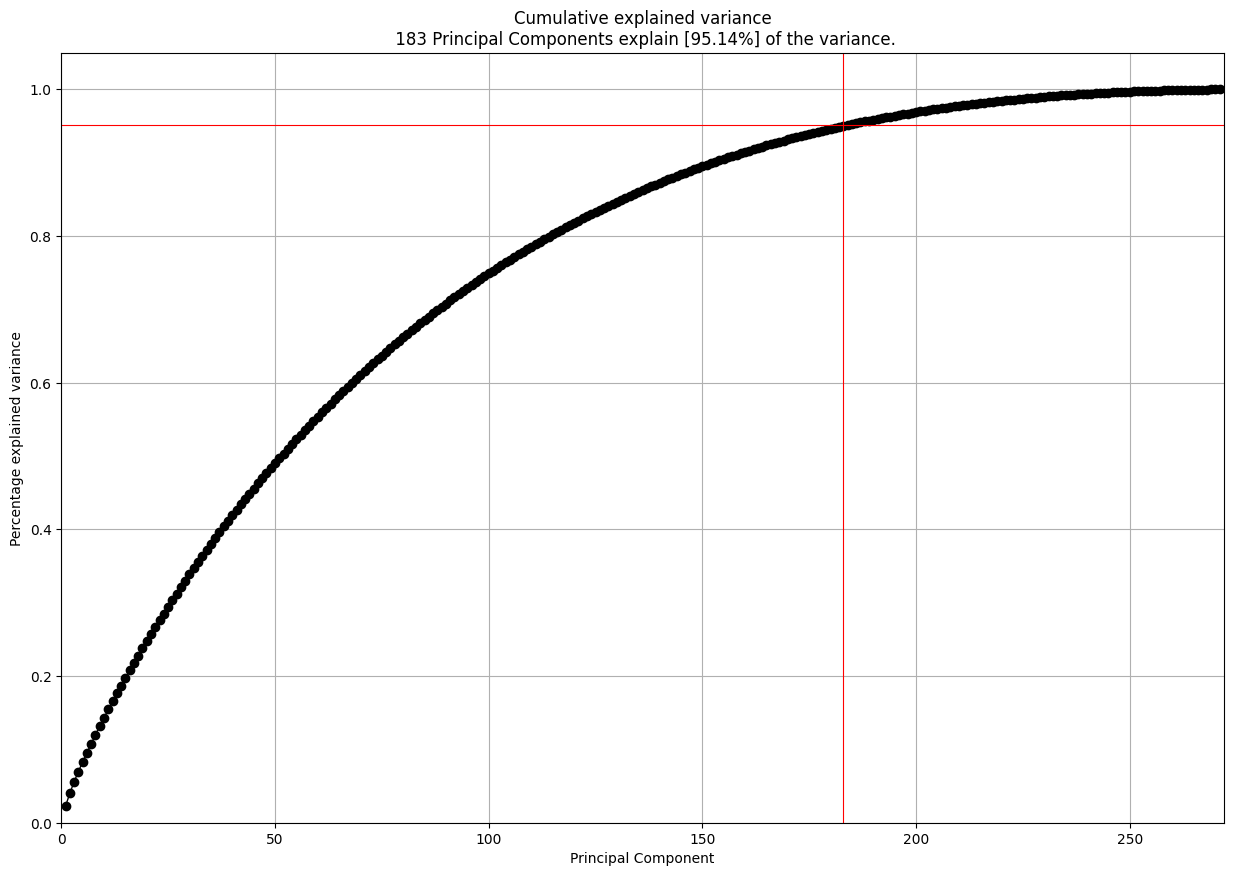

In [6]:
# Obtain PCA
ad_pca = pca()
x_ad_pca = ad_pca.fit_transform(x_ad)

ad_pca.plot()
print(x_ad_pca["topfeat"].to_markdown())

[10-11-2025 11:15:42] [pca.pca] [INFO] Plot PC1 vs PC2 vs PC3 with loadings.
[10-11-2025 11:15:42] [scatterd.scatterd] [INFO] Create scatterplot


(<Figure size 3000x2500 with 1 Axes>,
 <Axes3D: title={'center': '183 Principal Components explain [95.14%] of the variance'}, xlabel='PC1 (2.28% expl.var)', ylabel='PC2 (1.70% expl.var)', zlabel='PC3 (1.59% expl.var)'>)

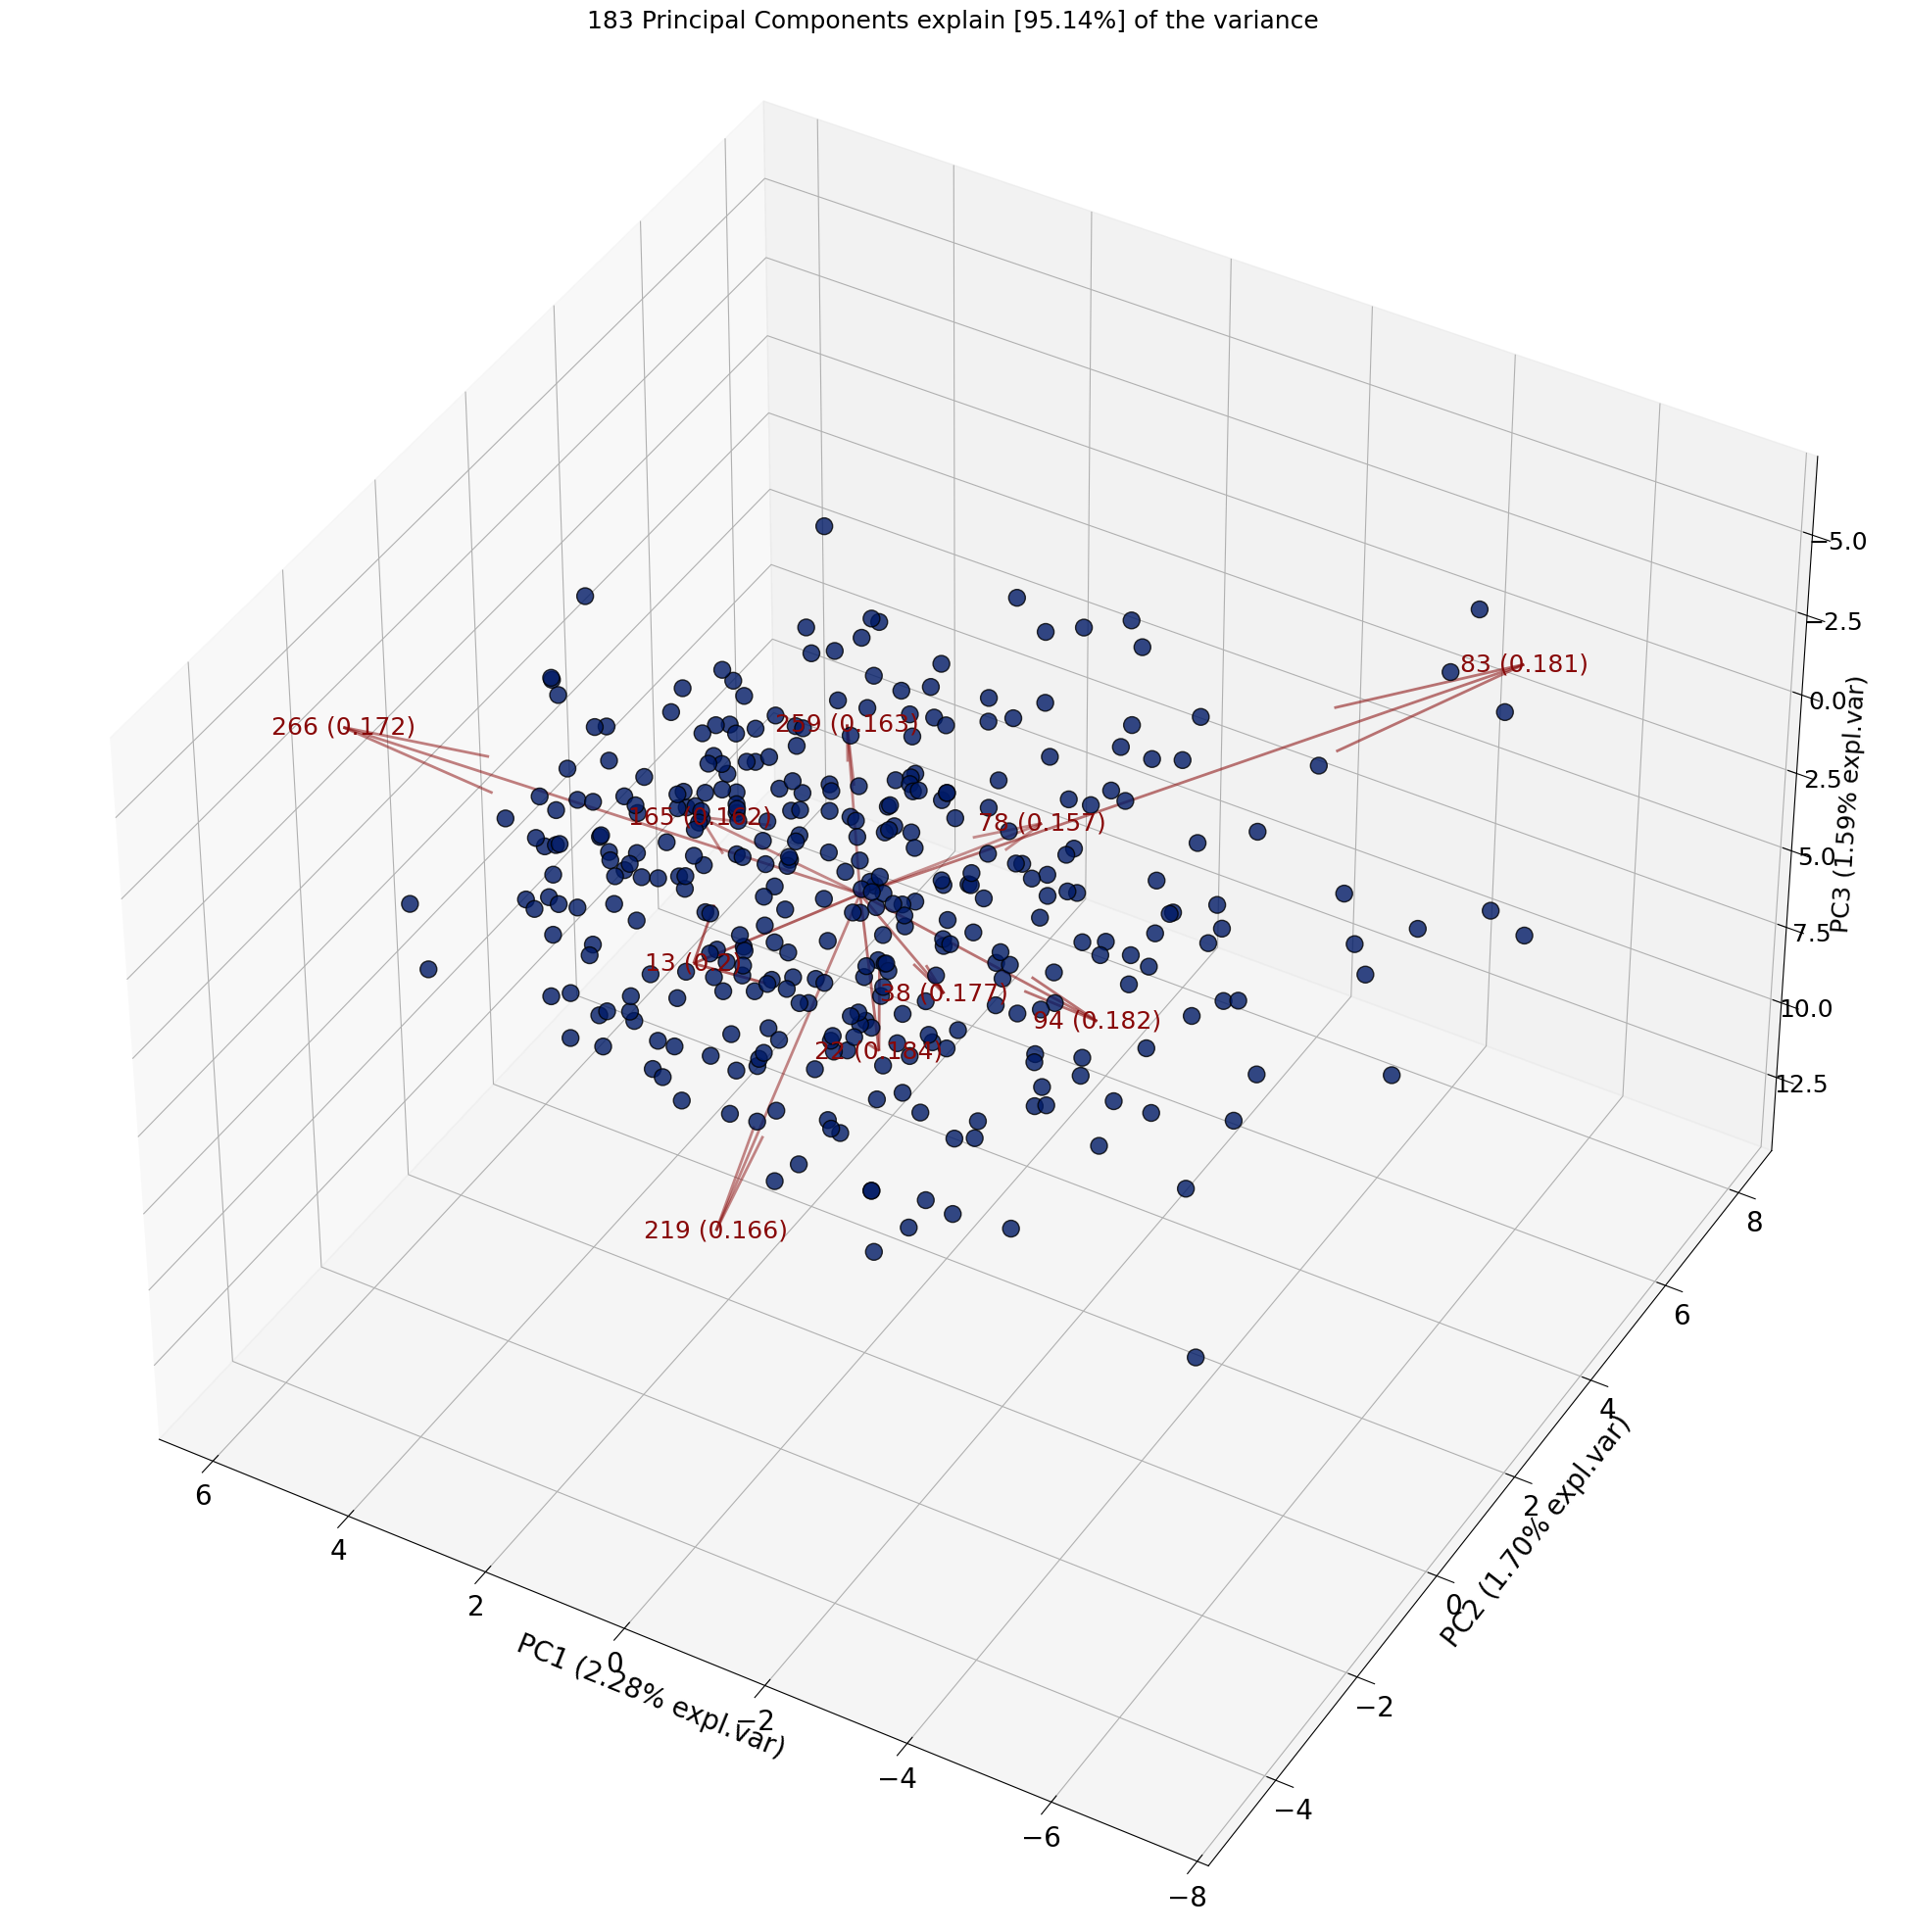

In [7]:
ad_pca.biplot3d(n_feat=10, legend=False)

### MLP Classification


In [8]:
# Extremely basic MLP for overfit
clf = MLPClassifier(
    random_state=RANDOM_STATE, solver="lbfgs", hidden_layer_sizes=(64, 32)
)
clf.fit(x_ad, y_ad)
clf.score(x_ad, y_ad)

1.0

In [9]:
# Holdout Test with basic MLP
ratios = np.arange(0.05, 1, 0.05)


def test_ratio(ratio):
    scores_at_ratio = []

    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            x_ad, y_ad, random_state=randint(1, 100000), test_size=ratio
        )

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        clf = MLPClassifier(
            random_state=RANDOM_STATE, solver="lbfgs", hidden_layer_sizes=(64, 32)
        )
        clf.fit(X_train, y_train)
        scores_at_ratio.append(clf.score(X_test, y_test))

    return scores_at_ratio


scores = pqdm(ratios, test_ratio, n_jobs=2)

y = np.mean(scores, axis=1)

QUEUEING TASKS | :   0%|          | 0/19 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/19 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/19 [00:00<?, ?it/s]

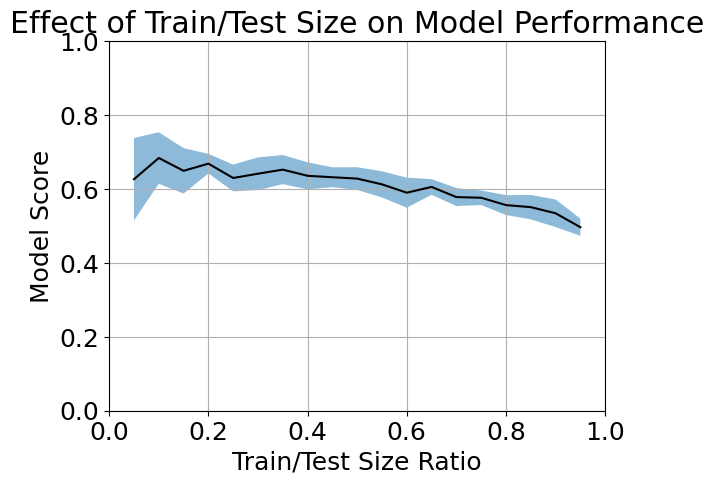

In [10]:
plt.plot(ratios, y, "k-")
plt.fill_between(
    ratios, y - np.std(scores, axis=1), y + np.std(scores, axis=1), alpha=0.5
)
plt.xlabel("Train/Test Size Ratio")
plt.ylabel("Model Score")
plt.title("Effect of Train/Test Size on Model Performance")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.show()

In [11]:
# Test of alpha, reinvent cv wheel
scores = []
scores_tbi = []
alpha = np.geomspace(1e-8, 10, num=50)


def test_alpha(a):
    scores_at_alpha = []
    scores_at_alpha_tbi = []

    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            x_ad, y_ad, random_state=randint(1, 100000), test_size=0.2
        )

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        X_tbi = scaler.transform(x_tbi)

        clf = MLPClassifier(
            alpha=a, max_iter=1000, solver="lbfgs", hidden_layer_sizes=(64, 32)
        )
        clf.fit(X_train, y_train)

        scores_at_alpha.append(clf.score(X_test, y_test))
        scores_at_alpha_tbi.append(clf.score(X_tbi, y_tbi))

    return (scores_at_alpha, scores_at_alpha_tbi)


results = pqdm(alpha, test_alpha, n_jobs=12)
scores, scores_tbi = zip(*results)

y = np.mean(scores, axis=1)
alpha_y_tbi = np.mean(scores_tbi, axis=1)

QUEUEING TASKS | :   0%|          | 0/50 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/50 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/50 [00:00<?, ?it/s]

TypeError: 'NameError' object is not iterable

In [ ]:
plt.semilogx(alpha, y, "k-", label="AD/HC")
plt.fill_between(
    alpha,
    y - np.std(scores, axis=1),
    y + np.std(scores, axis=1),
    alpha=0.5,
    color="black",
)

plt.semilogx(alpha, alpha_y_tbi, "r-", label="TBI+/TBI-")
plt.fill_between(
    alpha,
    alpha_y_tbi - np.std(scores_tbi, axis=1),
    alpha_y_tbi + np.std(scores_tbi, axis=1),
    alpha=0.5,
    color="red",
)

plt.xlabel("MLP Alpha")
plt.ylabel("Model Score")
plt.title("Effect of MLP Alpha Value on Model Performance")
plt.ylim(0, 1)
# plt.xlim(0, 10)
plt.grid("both")
plt.legend()
plt.show()